# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

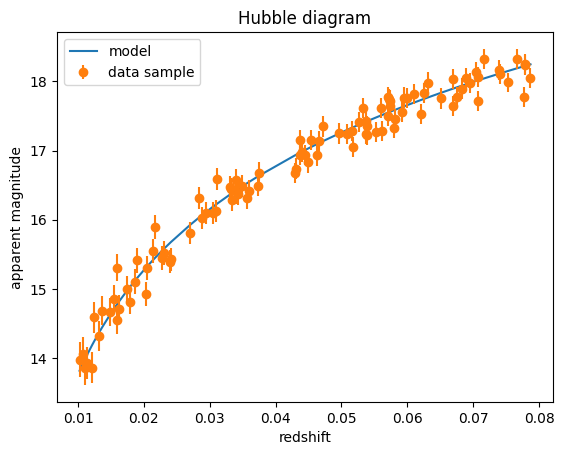

In [14]:
# TODO: generate and plot data with error bars
snssample = make_synthetic_sample()

mag_list = []
for z_iter in snssample.z :
    mag_list.append(mag_model(z_iter, 73, -19.3))

plt.plot(snssample.z, mag_list, label="model")

plt.errorbar(snssample.z, snssample.m, yerr=snssample.sigma_m, fmt='o', label="data sample")

plt.xlabel("redshift")
plt.ylabel("apparent magnitude")
plt.title("Hubble diagram")
plt.legend()
plt.show()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [15]:
# TODO: define chi2 function
def chi2(h0,m, x, y, sigma):
    """
    x and y are array
    """
    model = mag_model(x, h0, m)
    chi2_val = np.sum(((y - model)/sigma)**2)
    return chi2_val

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

In [16]:
# TODO: use numpy or scipy to minimize chi2
# best_fit of H0 = ...
num_iter= 10000
M=-19.3
H0_list = np.linspace(65,80,num_iter)
chi2_list_H0_vary = []

for H0 in H0_list :
    chi2_list_H0_vary.append(chi2(H0, M, snssample.z, snssample.m, snssample.sigma_m))

best_fit_H0 = H0_list[np.argmin(chi2_list_H0_vary)]
print(best_fit_H0)

73.57635763576357


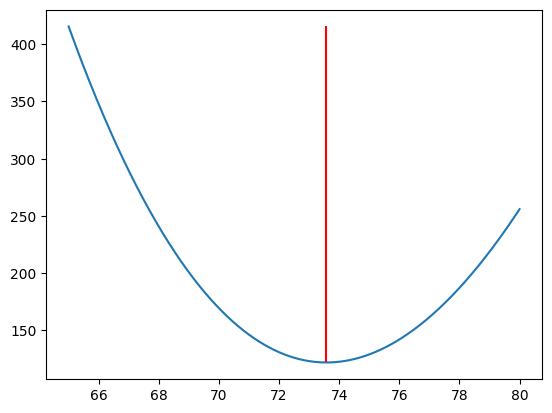

In [17]:
plt.plot(H0_list, chi2_list_H0_vary)
plt.vlines(best_fit_H0, ymin=min(chi2_list_H0_vary), ymax=max(chi2_list_H0_vary), colors='r',)

In [18]:
# TODO: say something about goodness of fit

print(chi2(best_fit_H0, M, snssample.z, snssample.m, snssample.sigma_m))

121.92615431487376


Text(0.5, 1.0, 'residuals')

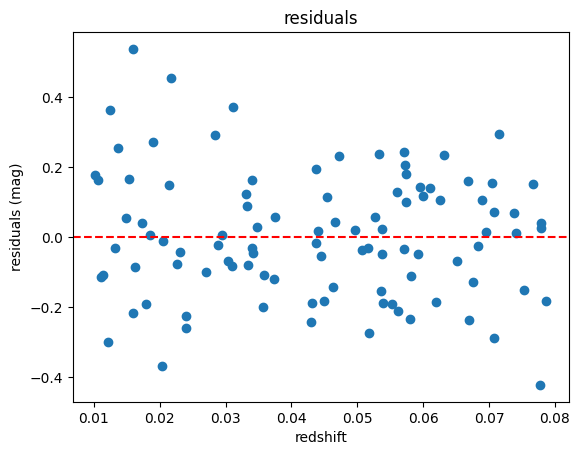

In [19]:
# TODO: plot residuals, always!
residuals = snssample.m - mag_model(snssample.z, best_fit_H0, M)
plt.plot(snssample.z, residuals, 'o')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("redshift")
plt.ylabel("residuals (mag)")
plt.title("residuals")

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

Bootstrap median H0 = 73.60 km/s/Mpc
Bootstrap 68% interval: [73.05, 74.15] km/s/Mpc


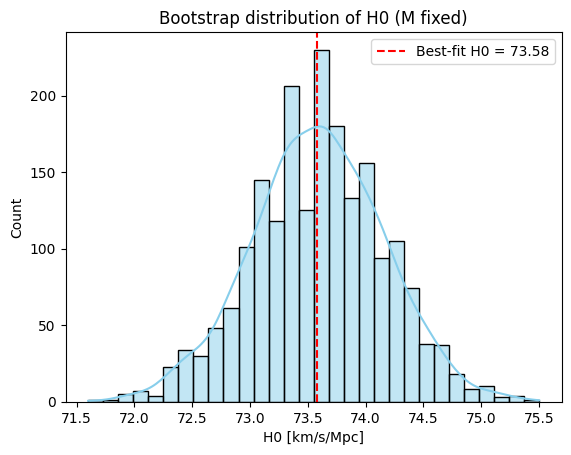

In [20]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement,
# fit each resampled dataset, 
# and collect the best-fit parameters to estimate uncertainties.

import seaborn as sns
def best_fit_H0_given_M(sn: SNSample, M, H0_grid=np.linspace(50, 90, 801)):
    chi2_vals = np.array([chi2(H0, M, sn.z, sn.m, sn.sigma_m) for H0 in H0_grid])
    j = np.argmin(chi2_vals)
    return H0_grid[j], chi2_vals, H0_grid

def conf_interval_from_delta_chi2(H0_grid, chi2_vals, dof=1, delta=1.0):
    # For 1 parameter, Delta chi^2 = 1 gives ~68% CI.
    j = np.argmin(chi2_vals)
    chi2_min = chi2_vals[j]
    mask = chi2_vals <= chi2_min + delta
    H0_in = H0_grid[mask]
    return H0_grid[j], H0_in.min(), H0_in.max()

def bootstrap_H0(sn: SNSample, M, nboot=500, rng=None):
    """
    Estimate the uncertainty in H0 by bootstrapping the SN sample.

    Parameters
    ----------
    sn : SNSample
        The supernova sample (with z, m, sigma_m arrays).
    M : float
        The assumed absolute magnitude of the supernovae.
    nboot : int, optional
        Number of bootstrap resamples (default: 500).
    rng : np.random.Generator or None, optional
        Random number generator or seed (default: None).

    Returns
    -------
    np.ndarray
        Array of best-fit H0 values from each bootstrap resample.
    """
    rng = np.random.default_rng(rng)
    H0s = []
    idx = np.arange(len(sn.z))
    H0_grid = np.linspace(50, 90, 801) # same grid as before
    for _ in range(nboot):
        # Resample SN indices with replacement
        sel = rng.choice(idx, size=len(idx), replace=True)
        # Create a new SNSample with the resampled data
        sn_b = SNSample(sn.z[sel], sn.m[sel], sn.sigma_m[sel], name=sn.name)
        # Find best-fit H0 for this resample
        hbest, chi2_vals, Hg = best_fit_H0_given_M(sn_b, M, H0_grid=H0_grid)
        H0s.append(hbest)
    return np.array(H0s)


H0_boot = bootstrap_H0(snssample, M, nboot=2000, rng=42)
h_med = np.median(H0_boot)
h_lo, h_hi = np.percentile(H0_boot, [16, 84])
print(f"Bootstrap median H0 = {h_med:.2f} km/s/Mpc")
print(f"Bootstrap 68% interval: [{h_lo:.2f}, {h_hi:.2f}] km/s/Mpc")

plt.figure()
sns.histplot(H0_boot, bins=30, kde=True, stat="count", color="skyblue", edgecolor="k")
plt.axvline(best_fit_H0, color='r', linestyle='--', label=f'Best-fit H0 = {best_fit_H0:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Count')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [21]:
# TODO: let's calculate a p-value from the sampled probability

### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

In [ ]:
def posterior(evidence, likelihood, prior):
    return (likelihood * prior) / evidence

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [ ]:
# TODO: implement grid posterior evaluation

M_list = np.linspace(-19.5, -19.0, 1000)

M_mean, M_sigma = np.mean(M_list), np.std(M_list)

def prior_H0(h):
    if 65 <= h <= 80:
        return 1
    else :
        return 0
def prior_M(m):
    coeff = 1/(M_sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((m - M_mean)/M_sigma)**2
    return coeff * np.exp(exponent)



### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [23]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [24]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare